In [212]:
%load_ext autoreload
%autoreload 2
from logistic import LogisticRegression, GradientDescentOptimizer
import torch
from matplotlib import pyplot as plt

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Link to logistic.py on GitHub:
https://github.com/jjr2024/github_jjr2024.github.io/blob/main/posts/logistic-regression/logistic.py

## Introduction

In this blog post, I drop down a level of abstraction from prior work in the class to implement the logistic regression model. I run multiple experiments to confirm the validity of my implementation and to see how the model reacts to changes in hyperparameters (specifically beta and number of features). I find that beta > 0 allows for a faster convergence to a zero or near-zero loss and that when the number of features > number of observations, the model is prone to overfitting.

## Part A: Implement Logistic Regression

The below function generates data for a classication problem: n_points controls the number of observations generated. Noise determines the difficulty of the problem. p_dims controls the number of features.

In [213]:
def classification_data(n_points = 300, noise = 0.2, p_dims = 2):
    
    y = torch.arange(n_points) >= int(n_points/2)
    y = 1.0*y
    X = y[:, None] + torch.normal(0.0, noise, size = (n_points,p_dims))
    X = torch.cat((X, torch.ones((X.shape[0], 1))), 1)
    
    return X, y

The below defines a function, train(), that trains the logistic regression model on X, y inputs and keeps track of the evolution of the loss over time via the loss_vec. Train() has parameters for the maximum number of update iterations (max_iterations), as well as for the learning rate (a) and the momentum rate (b). 

In [214]:
LR = LogisticRegression() 
opt = GradientDescentOptimizer(LR)

loss_vec = []

X, y = classification_data(n_points = 100, noise = 0.1)

def train(X, y, max_iterations = 1000, a = 0.1, b = 0.9):
    for _ in range(max_iterations):
        loss = LR.loss(X, y) 
        loss_vec.append(loss)
        opt.step(X, y, a, b)

train(X,y,1000,0.1,0.9)

The below is code defining two functions that assist in visualizing our results. plot_perceptron_data and draw_line visualize our datapoints and our weight vector, respectively.

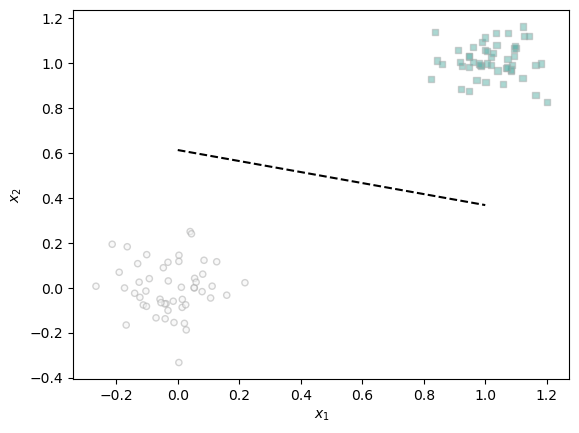

In [215]:
def plot_perceptron_data(X, y, ax):
    assert X.shape[1] == 3, "This function only works for data created with p_dims == 2"
    targets = [0, 1]
    markers = ["o" , ","]
    for i in range(2):
        ix = y == targets[i]
        ax.scatter(X[ix,0], X[ix,1], s = 20,  c = y[ix], facecolors = "none", edgecolors = "darkgrey", cmap = "BrBG", vmin = -2, vmax = 2, alpha = 0.5, marker = markers[i])
    ax.set(xlabel = r"$x_1$", ylabel = r"$x_2$")

fig, ax = plt.subplots(1, 1)
plot_perceptron_data(X, y, ax)

def draw_line(w, x_min, x_max, ax, **kwargs):
    w_ = w.flatten()
    x = torch.linspace(x_min, x_max, 101)
    y = -(w_[0]*x + w_[2])/w_[1]
    l = ax.plot(x, y, **kwargs)

draw_line(LR.w, 0, 1, ax, color = "black", linestyle = "dashed", label = "weight vector w")


## Part B: Experiments
### Experiment 1: Vanilla Gradient Descent 

In this first experiment, our data has two features, alpha is small (0.2), and beta = 0. This experiment confirms that our code in Part A is likely correct.

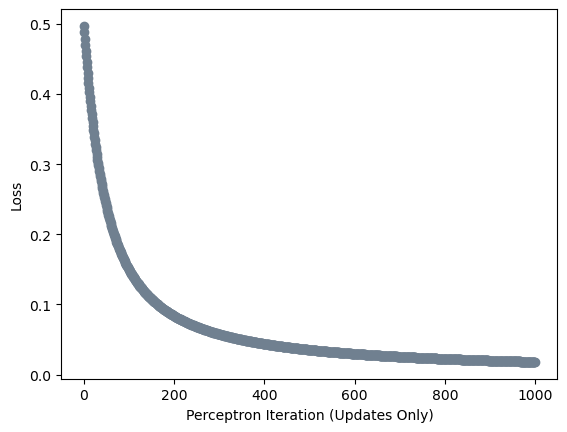

In [216]:
LR = LogisticRegression() 
opt = GradientDescentOptimizer(LR)

loss_vec = []

X, y = classification_data(n_points = 100, noise = 0.1, p_dims = 2)

train(X,y,1000,a=0.2,b=0.0)

plt.plot(loss_vec, color = "slategrey")
plt.scatter(torch.arange(len(loss_vec)), loss_vec, color = "slategrey")
labs = plt.gca().set(xlabel = "Perceptron Iteration (Updates Only)", ylabel = "Loss")

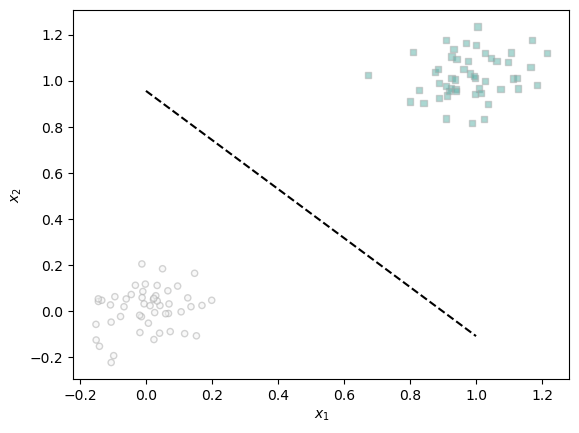

In [217]:
fig, ax = plt.subplots(1, 1)
plot_perceptron_data(X, y, ax)
draw_line(LR.w, 0, 1, ax, color = "black", linestyle = "dashed", label = "weight vector w")

The above visualization shows that our data is linearly separable and that our weight vector correctly classifies the data with 100% accuracy.

### Experiment 2: Benefits of Momentum

In this experiment, we set beta = 0.9 to see the benefits of momentum, with which we need fewer iterations to approach a loss of 0.

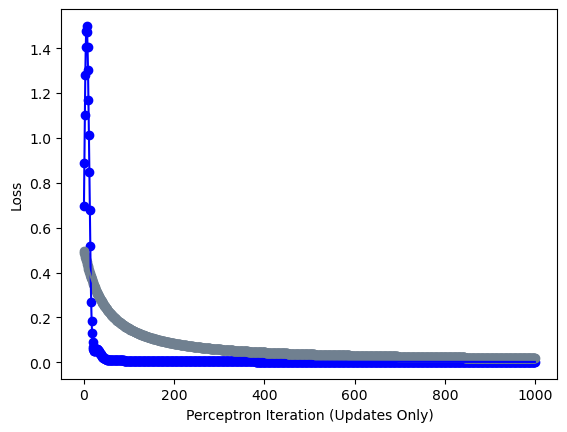

In [218]:
LR = LogisticRegression() 
opt = GradientDescentOptimizer(LR)

loss_vec2 = loss_vec

loss_vec = []

#No classification_data call so that we use same dataset

train(X,y,1000,a=0.2,b=0.9)

plt.plot(loss_vec, color = "blue")
plt.plot(loss_vec2, color = "slategrey")
plt.scatter(torch.arange(len(loss_vec)), loss_vec, color = "blue")
plt.scatter(torch.arange(len(loss_vec2)), loss_vec2, color = "slategrey")
labs = plt.gca().set(xlabel = "Perceptron Iteration (Updates Only)", ylabel = "Loss")

The blue line indicates our loss vector when we train our model with b = 0.9. The grey line is the loss vector from Experiment 1. We see early on that momentum can work against us initially, but ultimately does lead to a faster zero or near-zero loss.

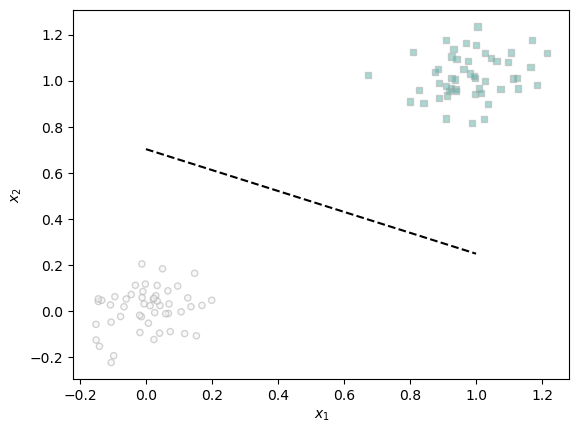

In [219]:
fig, ax = plt.subplots(1, 1)
plot_perceptron_data(X, y, ax)
draw_line(LR.w, 0, 1, ax, color = "black", linestyle = "dashed", label = "weight vector w")

Again we achieve 100% accuracy in classification, as shown by our weight vector accurately separating the two groups of data.

### Experiment 3: Overfitting

In this experiment, we set the number of observations (15) to be half the number of features (30). We also create two sets of classification data, each with 15 observations, to see how our logistic regression model overfits to the training data and sees a deterioration in accuracy on our test data.

In [233]:
LR = LogisticRegression() 
opt = GradientDescentOptimizer(LR)

loss_vec = []

X_train, y_train = classification_data(n_points = 15, noise = 0.5, p_dims = 30)
X_test, y_test = classification_data(n_points = 15, noise = 0.5, p_dims = 30)


train(X_train,y_train,100,a=0.1,b=0.0)

(LR.predict(X_train) == y_train).float().mean(), (LR.predict(X_test) == y_test).float().mean()

(tensor(1.), tensor(0.9333))

Above, the first tensor, 1., reflects our 100% accuracy on our training. The second tensor reflects 93.33% accuracy in our testing data set.

The difference in accuracy rates reflects our model's overfitting on the training set.

## Part C: Writing / Conclusion

In this blog post, I run experiments to confirm the validity of my implementation and to see how the model reacts to changes in hyperparameters (specifically beta and number of features). I find that beta > 0 allows for a faster convergence to a zero or near-zero loss and that when the number of features > number of observations, the model is prone to overfitting.

In writing this blog post, I learned about why momentum is useful for gradient descent and why in practice beta = 0.9 is common. I gained more familiarity turning mathematical equations into code. I had a more efficient process than previous posts because of more effective debugging, especially by knowing what to look for (the shape() function to different tensors was extremely useful to know when I did something wrong).